In [85]:
# load in entity_const.csv into a df
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

entity_const = pd.read_csv('../data/entity_const.csv')
entity_const

MP_geometry = pd.read_csv('../data/MP_geometry.csv')
MP_geometry = gpd.GeoDataFrame(MP_geometry)
MP_geometry['geometry'] = gpd.GeoSeries.from_wkt(MP_geometry['geometry'])


# load questions
questions = pd.read_csv('../data/questions.csv')
questions.columns

Index(['question', 'qnum', 'person', 'wikidataperson', 'text', 'date'], dtype='object')

In [86]:
MP_geometry.constLabel.unique()

array(['Witney', 'Gower', 'Dumfries and Galloway', 'Blaydon',
       'Banff and Buchan', 'Nottingham North', 'Gedling', 'Putney',
       'Enfield North', 'Stockton South', 'Blyth Valley',
       'Penistone and Stocksbridge', 'City of Durham', 'Guildford',
       'South West Hertfordshire', 'Bishop Auckland', 'Bury North',
       'North West Durham', 'Ashfield', 'Aylesbury',
       'Chesham and Amersham', 'West Worcestershire', 'East Antrim',
       'Broxbourne', 'Wyre and Preston North', 'Calder Valley',
       'Birmingham Hodge Hill', 'Bournemouth West', 'East Ham',
       'South Basildon and East Thurrock', 'Folkestone and Hythe',
       'Torridge and West Devon', 'Ludlow', 'Northampton North',
       'Sefton Central', 'Wokingham', 'Basingstoke', 'Carlisle',
       'Makerfield', 'Blaenau Gwent', 'Rayleigh and Wickford',
       'North Wiltshire', 'Stretford and Urmston', 'West Suffolk',
       'Castle Point', 'Reading West', 'Hemel Hempstead',
       'Newcastle upon Tyne Central', 'So

In [87]:
questions.head(3)

,question,qnum,person,wikidataperson,text,date
0,https://id.parliament.uk/0IwOO533,903422,https://id.parliament.uk/Vs3bGLNz,http://www.wikidata.org/entity/Q689287,Which three departments had the lowest proport...,2023-01-05+00:00
1,https://id.parliament.uk/dRJ9254g,117748,https://id.parliament.uk/eD0yd5Ec,http://www.wikidata.org/entity/Q19871931,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00
2,https://id.parliament.uk/e4IDRkKi,117410,https://id.parliament.uk/RlIqlixq,http://www.wikidata.org/entity/Q695228,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00


In [88]:
entity_const

,question,entity,easting,northing,wikipedia,const
0,https://id.parliament.uk/wne3Q3kQ,West_Midlands_(region),382689.369764,286801.459728,https://en.wikipedia.org/wiki/West_Midlands_(r...,South Staffordshire
1,https://id.parliament.uk/Q0uNVDhz,Slough,498082.779241,179773.798368,https://en.wikipedia.org/wiki/Slough,Slough
2,https://id.parliament.uk/oHeIeP9G,River_Tees,455114.463816,528466.390692,https://en.wikipedia.org/wiki/River_Tees,Redcar
3,https://id.parliament.uk/W7K6780e,Hounslow,512974.190267,175455.283371,https://en.wikipedia.org/wiki/Hounslow,Feltham and Heston
4,https://id.parliament.uk/e9R3Yc8s,Buckingham_(UK_Parliament_constituency),469572.352087,233989.735822,https://en.wikipedia.org/wiki/Buckingham_(UK_P...,Buckingham
...,...,...,...,...,...,...
2580,https://id.parliament.uk/KBjXJ9mO,Portsmouth,464413.884270,101094.379827,https://en.wikipedia.org/wiki/Portsmouth,Portsmouth South
2581,https://id.parliament.uk/51DqbupU,HM_Prison_Wandsworth,526728.635699,173925.158213,https://en.wikipedia.org/wiki/HM_Prison_Wandsw...,Tooting
2582,https://id.parliament.uk/c7mhUeV3,Rathlin_Island,133639.823902,608129.542743,https://en.wikipedia.org/wiki/Rathlin_Island,North Antrim
2583,https://id.parliament.uk/Py4BvdeG,Downing_Street_mortar_attack,530021.784566,179958.304242,https://en.wikipedia.org/wiki/Downing_Street_m...,Cities of London and Westminster


In [89]:
entity_const

,question,entity,easting,northing,wikipedia,const
0,https://id.parliament.uk/wne3Q3kQ,West_Midlands_(region),382689.369764,286801.459728,https://en.wikipedia.org/wiki/West_Midlands_(r...,South Staffordshire
1,https://id.parliament.uk/Q0uNVDhz,Slough,498082.779241,179773.798368,https://en.wikipedia.org/wiki/Slough,Slough
2,https://id.parliament.uk/oHeIeP9G,River_Tees,455114.463816,528466.390692,https://en.wikipedia.org/wiki/River_Tees,Redcar
3,https://id.parliament.uk/W7K6780e,Hounslow,512974.190267,175455.283371,https://en.wikipedia.org/wiki/Hounslow,Feltham and Heston
4,https://id.parliament.uk/e9R3Yc8s,Buckingham_(UK_Parliament_constituency),469572.352087,233989.735822,https://en.wikipedia.org/wiki/Buckingham_(UK_P...,Buckingham
...,...,...,...,...,...,...
2580,https://id.parliament.uk/KBjXJ9mO,Portsmouth,464413.884270,101094.379827,https://en.wikipedia.org/wiki/Portsmouth,Portsmouth South
2581,https://id.parliament.uk/51DqbupU,HM_Prison_Wandsworth,526728.635699,173925.158213,https://en.wikipedia.org/wiki/HM_Prison_Wandsw...,Tooting
2582,https://id.parliament.uk/c7mhUeV3,Rathlin_Island,133639.823902,608129.542743,https://en.wikipedia.org/wiki/Rathlin_Island,North Antrim
2583,https://id.parliament.uk/Py4BvdeG,Downing_Street_mortar_attack,530021.784566,179958.304242,https://en.wikipedia.org/wiki/Downing_Street_m...,Cities of London and Westminster


In [90]:
"""Number of questions that include each constituency"""

# group the entities extracted from the questions by constituency and count the number of entities in each constituency
entity_occurrences = pd.DataFrame(entity_const.groupby("const")["question"].count().sort_values(ascending=False)).reset_index()
entity_occurrences.rename(columns={"question": "occurrences"}, inplace=True)

# join to a df containing the geometry of each MP's constituency. We drop duplicates because some constituencies have had multiple MPs
entity_occurrences = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), entity_occurrences, left_on="constLabel", right_on="const", how="left")
entity_occurrences.drop(columns="const", inplace=True)

entity_occurrences = gpd.GeoDataFrame(entity_occurrences)

# set the geometry column
entity_occurrences = entity_occurrences.set_geometry("geometry")

# if a constituency has no mentions, fill the value with 0
entity_occurrences.fillna(0, inplace=True)



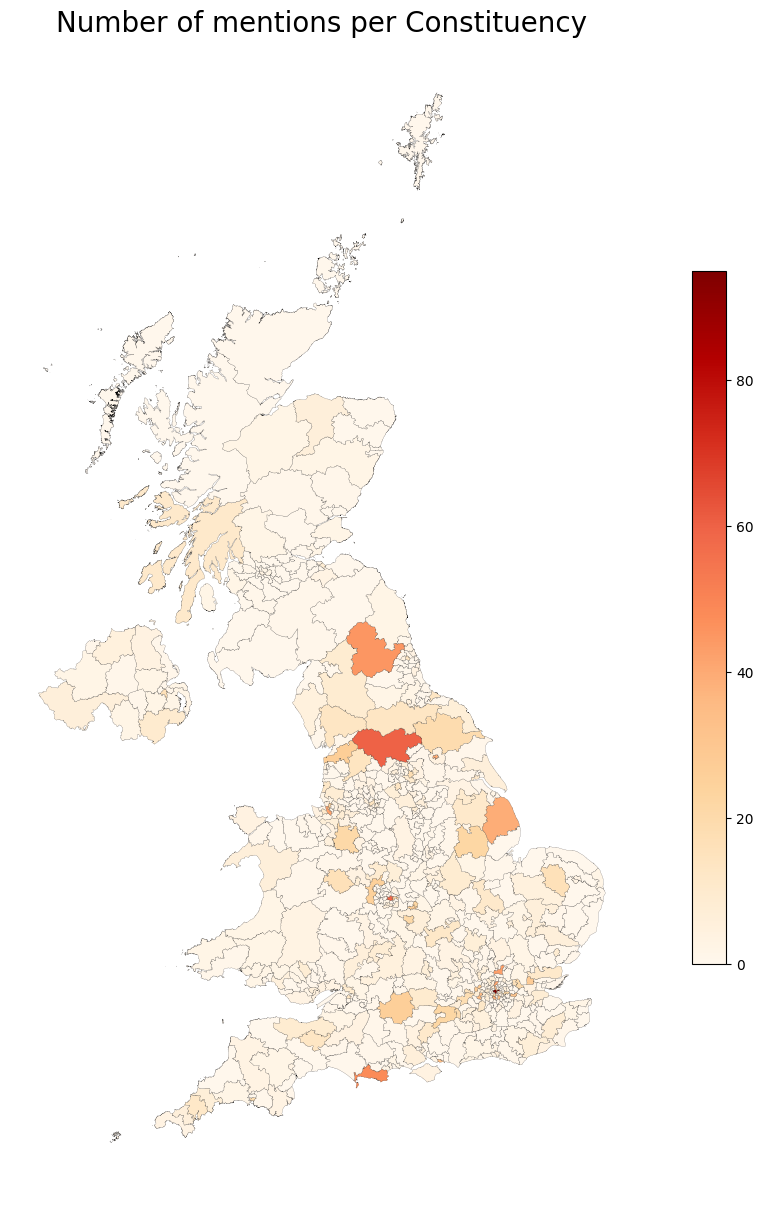

In [91]:
fig, ax = plt.subplots(figsize=(15, 15))


entity_occurrences.plot(ax=ax, column="occurrences", legend=True, cmap="OrRd" , edgecolor="black", linewidth=0.1, legend_kwds={"shrink":0.6}) #cmap="OrRd"
# centre title
plt.title("Number of mentions per Constituency", fontsize=20)
# remove axis labels
ax.set_axis_off()

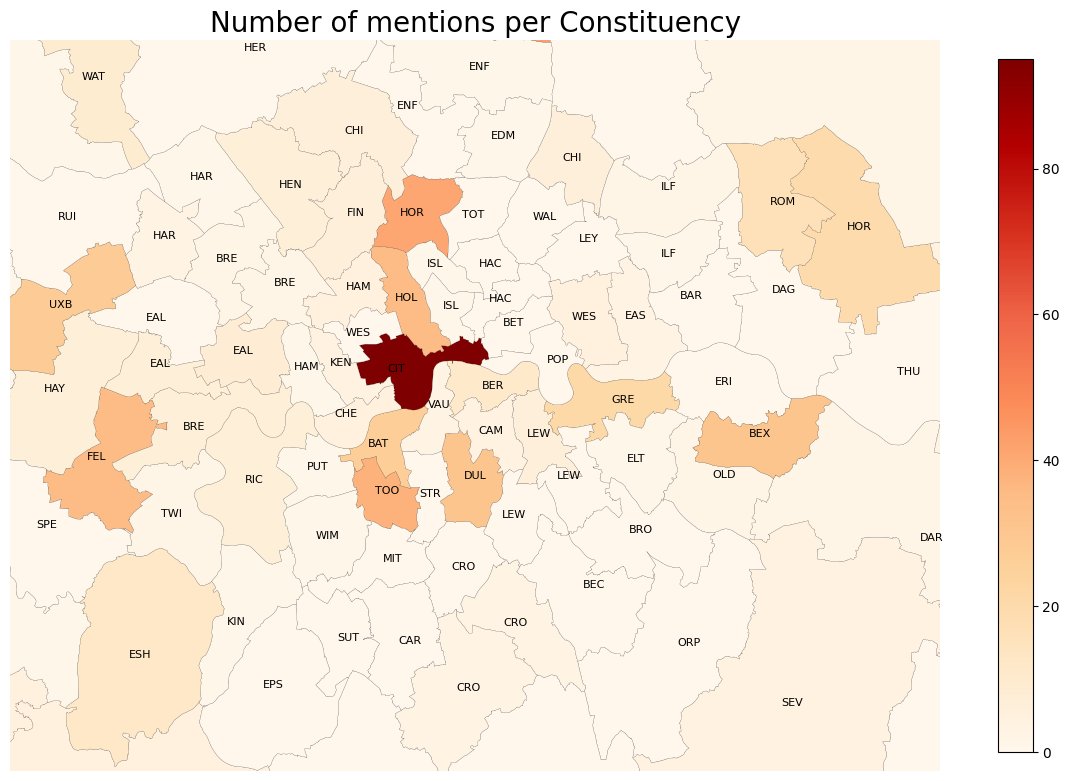

In [92]:
# Plots the number of mentions and limits the axes to inside London

fig, ax = plt.subplots(figsize=(15, 15))

entity_occurrences.plot(ax=ax, column="occurrences", legend=True, cmap="OrRd" , edgecolor="black", linewidth=0.1, legend_kwds={'shrink':0.6}) #cmap="OrRd"


# help to annotate the shapes https://stackoverflow.com/questions/38899190/geopandas-label-polygons 

# produce coordinates inside the polygon geometries to place the labels
entity_occurrences["coords"] = entity_occurrences["geometry"].apply(lambda x: x.representative_point().coords[:])
entity_occurrences["coords"] = [coords[0] for coords in entity_occurrences["coords"]]

for index, row in entity_occurrences.iterrows():
    plt.annotate(text=row["constLabel"][:3].upper(), xy=row["coords"], horizontalalignment='center', fontsize=8)

plt.title("Number of mentions per Constituency", fontsize=20)

# limit the axes to inside London
ax.set_ylim(156_000, 200_000)
ax.set_xlim(505_000, 561_000)
ax.set_axis_off()


In [93]:
"""Join the question entity with the MP who asked the question and their constituency"""

# a question was asked about this constituency by this MP who is from this place and has this area.


# merge the geometry of the MPs constituency with the entity in the question and the entity's constituency
joined_df = pd.merge(
            # merge the constituencies of entities with the specific question asking it
            # I have done this to get the MP who asked the question
            pd.merge(
                entity_const, questions, how="left", right_on="question", left_on="question"
                ), 
                
                MP_geometry, how="left", left_on="wikidataperson", right_on="person")




joined_df= joined_df[["question", "const_x", "personLabel", "constLabel", "geometry"]]

joined_df.rename(columns={"const_x":"question_const", "personLabel":"MP", "constLabel":"MP_const", "geometry":"MP_const_geometry"}, inplace=True)
joined_df

,question,question_const,MP,MP_const,MP_const_geometry
0,https://id.parliament.uk/wne3Q3kQ,South Staffordshire,Steve McCabe,Birmingham Selly Oak,"POLYGON ((402823.398 282975.698, 402819.399 28..."
1,https://id.parliament.uk/Q0uNVDhz,Slough,Tanmanjeet Singh Dhesi,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17..."
2,https://id.parliament.uk/oHeIeP9G,Redcar,Rachael Maskell,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45..."
3,https://id.parliament.uk/W7K6780e,Feltham and Heston,Ruth Cadbury,Brentford and Isleworth,"POLYGON ((521351.824 179500.313, 521353.700 17..."
4,https://id.parliament.uk/e9R3Yc8s,Buckingham,Julian Knight,Solihull,"POLYGON ((416312.499 283687.905, 416335.898 28..."
...,...,...,...,...,...
2580,https://id.parliament.uk/KBjXJ9mO,Portsmouth South,Stephen Morgan,Portsmouth South,"MULTIPOLYGON (((463418.899 101737.297, 464118...."
2581,https://id.parliament.uk/51DqbupU,Tooting,Rosena Allin-Khan,Tooting,"POLYGON ((525760.499 174242.503, 525769.000 17..."
2582,https://id.parliament.uk/c7mhUeV3,North Antrim,Andrew Rosindell,Romford,"POLYGON ((548106.898 193800.904, 548224.704 19..."
2583,https://id.parliament.uk/Py4BvdeG,Cities of London and Westminster,Emily Thornberry,Islington South and Finsbury,"POLYGON ((529818.713 184985.372, 529825.652 18..."


In [94]:
"""Number of questions per constituency."""

# group the questions by the constituency of the MP who asked the question and the geometry of the constituency
const_questions = pd.DataFrame(joined_df.groupby(["MP_const"])["MP"].count()
                               ).reset_index()
const_questions.rename(columns={"MP": "questions"}, inplace=True)

# add the names of the remaining constituencies that there MP have asked no questions, and join the geometry of all the constituencies back
const_questions = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), const_questions, left_on="constLabel", right_on="MP_const", how="left")
const_questions.drop(columns="MP_const", inplace=True)
const_questions.fillna(0, inplace=True)

const_questions.set_geometry("geometry")
const_questions = gpd.GeoDataFrame(const_questions)

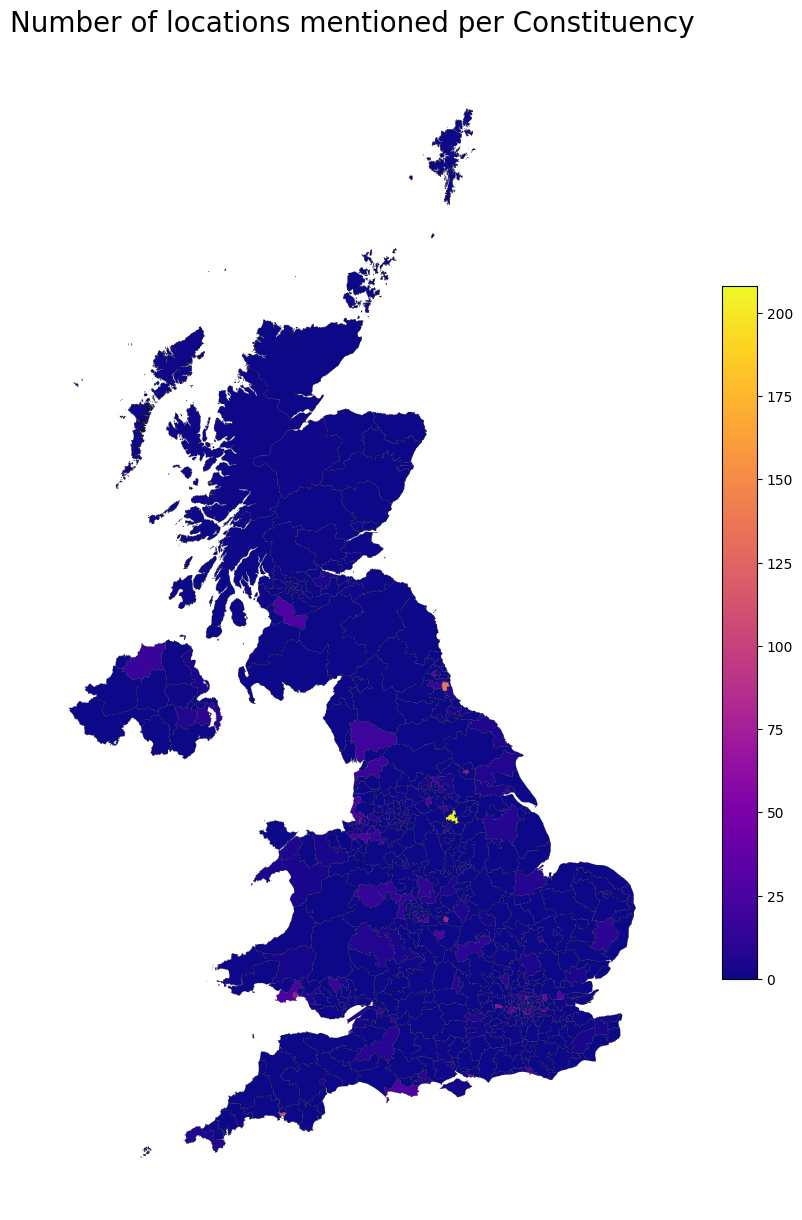

In [95]:
fig,ax = plt.subplots(figsize=(15, 15))
const_questions.plot(ax=ax, column="questions", legend=True, cmap="plasma" , edgecolor="black", linewidth=0.1, legend_kwds={"shrink":0.6})
plt.title("Number of locations mentioned per Constituency", fontsize=20)
ax.set_axis_off()

In [96]:
"""
Number of questions made by MPs about their own constituency

"""


# count the number of times for each entity that the MP's constituency is the same as the entitie's
joined_df["same_const"] = joined_df["question_const"] == joined_df["MP_const"]

same_const = joined_df.groupby("MP_const")["same_const"].sum().reset_index()
same_const["same_const"].min()

0

In [97]:
# take all entities mentioned by MPs about their own constituency
joined_df["same_const"] = joined_df["question_const"] == joined_df["MP_const"]

same_const = joined_df[joined_df["same_const"]]
same_const

# take each question by the MP that metions their constituency (by removing duplicates, where it is referenced multiple times in a question)
same_const = same_const.drop_duplicates(subset=["question"])
same_const = same_const.groupby("MP_const")["same_const"].count().reset_index()

# add geometries back for all constituencies
same_const = pd.merge(MP_geometry[["constLabel", "geometry"]].drop_duplicates(), same_const, left_on="constLabel", right_on="MP_const", how="left")
same_const.drop(columns="MP_const", inplace=True)
same_const = same_const.set_geometry("geometry")

question_counts = pd.merge(questions, MP_geometry[["person", "constLabel"]], left_on="wikidataperson", right_on="person").groupby(["constLabel"])["question"].count().reset_index()
question_counts.rename(columns={"question": "total_questions"}, inplace=True)

# fill in na for constituencies that have total questions greater than 0 for their same_const value
same_const = pd.merge(same_const, question_counts, on="constLabel", how="left")
same_const[~same_const["total_questions"].isna()] = same_const[~same_const["total_questions"].isna()].fillna(0)

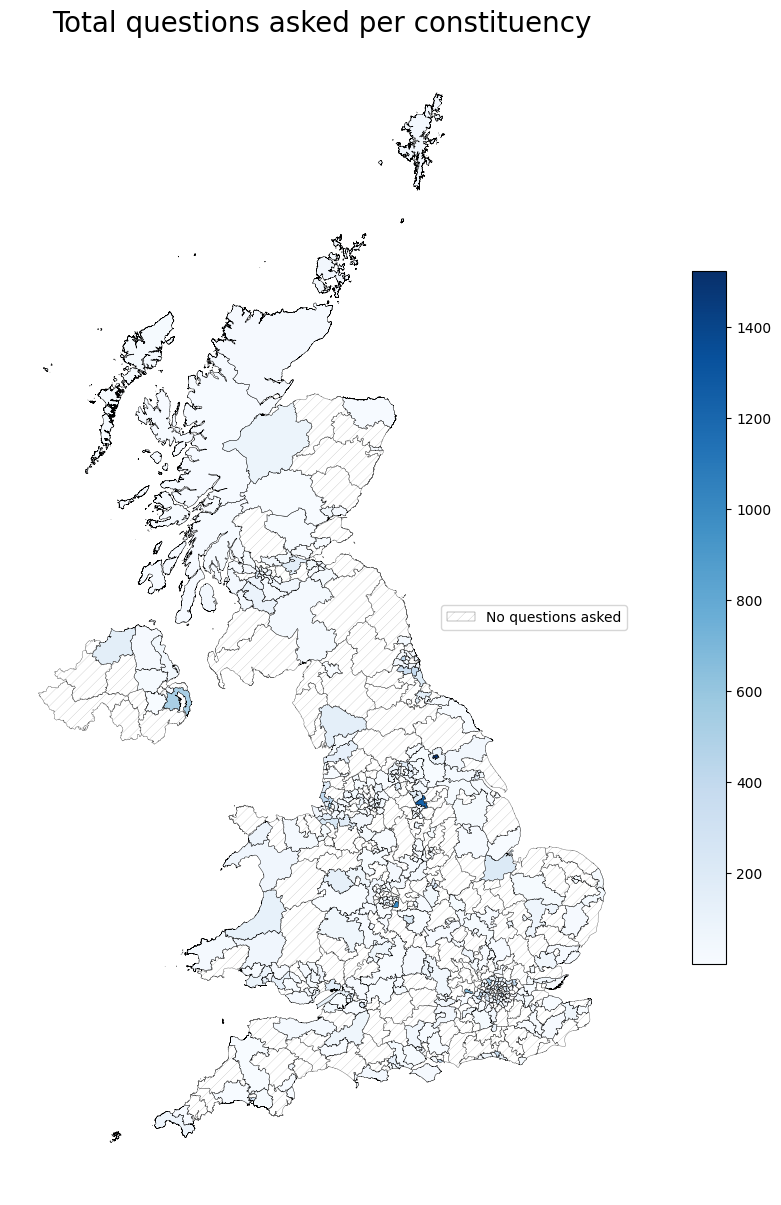

In [98]:
# help to make the second legend from
# https://stackoverflow.com/questions/57067623/geopandas-plotting-with-legend-filled-up-with-slash-lines
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(15, 15))


same_const.plot(ax=ax, column="total_questions", legend=True, cmap="Blues", edgecolor="black", linewidth=0.3,
                missing_kwds={
                    "color" : "white",
                    "edgecolor" : "black",
                    "linewidth" : 0.3,
                    "hatch" : "///",
                    "alpha" : 0.6
                },
                
                legend_kwds={"shrink":0.6},
                ) #cmap="OrRd"

LegendElement = [
                 mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='No questions asked', linewidth=0.3, alpha=0.6),
                ]
ax.legend(handles=LegendElement,loc='right')


plt.title("Total questions asked per constituency", fontsize=20)
# remove axis labels
ax.set_axis_off()
plt.rcParams['hatch.linewidth'] = 0.1


<Axes: xlabel='total_questions', ylabel='Count'>

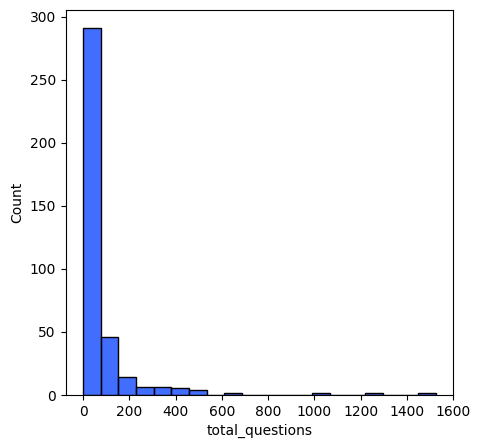

In [99]:
# plot the total questions and number of constituencies that asked that amount. It should be on a log scale
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=same_const, x="total_questions", bins=20)

In [185]:
total_questions.value_counts().sum()

376

Text(0.5, 1.0, 'Cumulative proportion of questions\n asked per constituency')

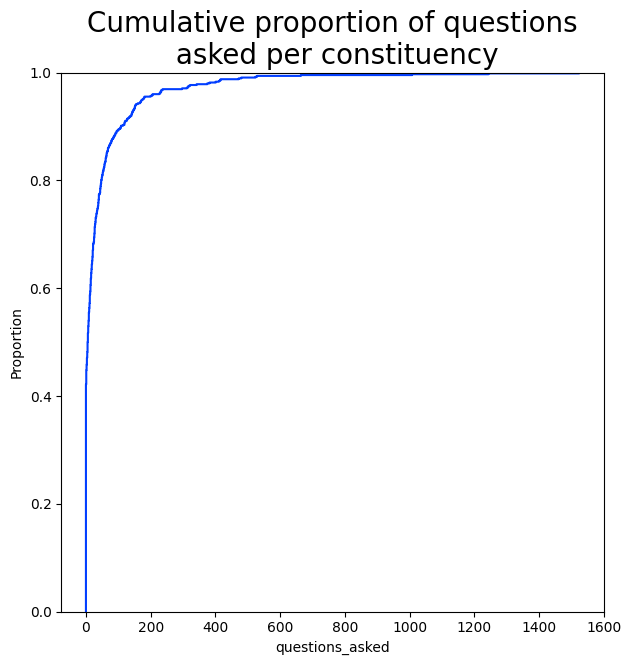

In [307]:
total_questions = same_const[["total_questions"]].sort_values(by="total_questions", ascending=False)
total_questions.fillna(0, inplace=True)
total_questions.rename(columns={"total_questions": "questions_asked"}, inplace=True)
fig, ax = plt.subplots(figsize=(7, 7))
sns.ecdfplot(data=total_questions, x="questions_asked", stat="proportion", ax=ax)
plt.title("Cumulative proportion of questions\n asked per constituency", fontsize=20)

Text(0.5, 1.0, 'Cumulative proportion of questions\n asked per constituency')

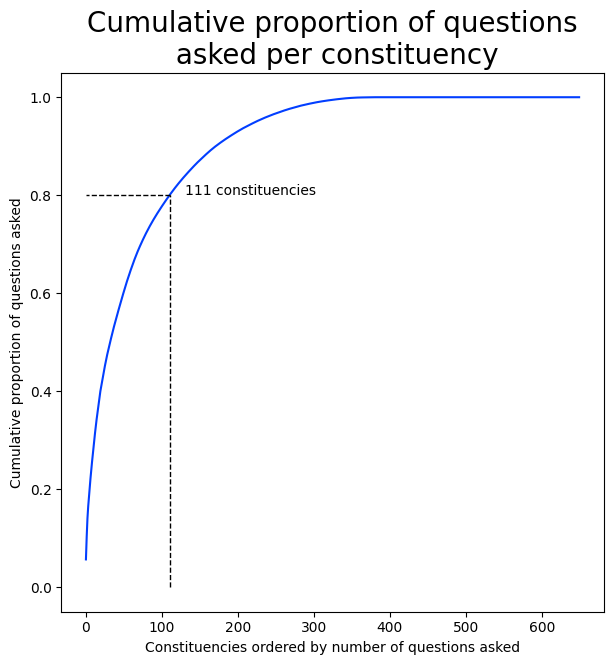

In [303]:

total_questions.sort_values(by="questions_asked", ascending=False)
total_questions.reset_index(inplace=True, drop=True)
# make the index a column

total_questions["cumulative"] = total_questions["questions_asked"].cumsum()
total_questions["cumulative_proportion"] = total_questions["cumulative"] / total_questions["cumulative"].max()

fig, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=range(len(total_questions)), y="cumulative_proportion", data=total_questions)

# plot pareto lines
first_80_row = total_questions[total_questions["cumulative_proportion"] >0.8].head(1)
ax.plot([first_80_row.index[0]+1, first_80_row.index[0]+1], [0, 0.8], color='black', linestyle='dashed', linewidth=1)
ax.plot([first_80_row.index[0]+1, 0], [0.8, 0.8], color='black', linestyle='dashed', linewidth=1)
ax.text(first_80_row.index[0]+20, 0.8, f"{first_80_row.index[0]+1} constituencies", fontsize=10)


ax.set_xlabel("Constituencies ordered by number of questions asked")
ax.set_ylabel("Cumulative proportion of questions asked")
ax.set_title("Cumulative proportion of questions\n asked per constituency", fontsize=20)

In [294]:
total_questions[total_questions["cumulative_proportion"] >0.8].head(1)

,questions_asked,cumulative,cumulative_proportion
110,58.0,21493.0,0.800037


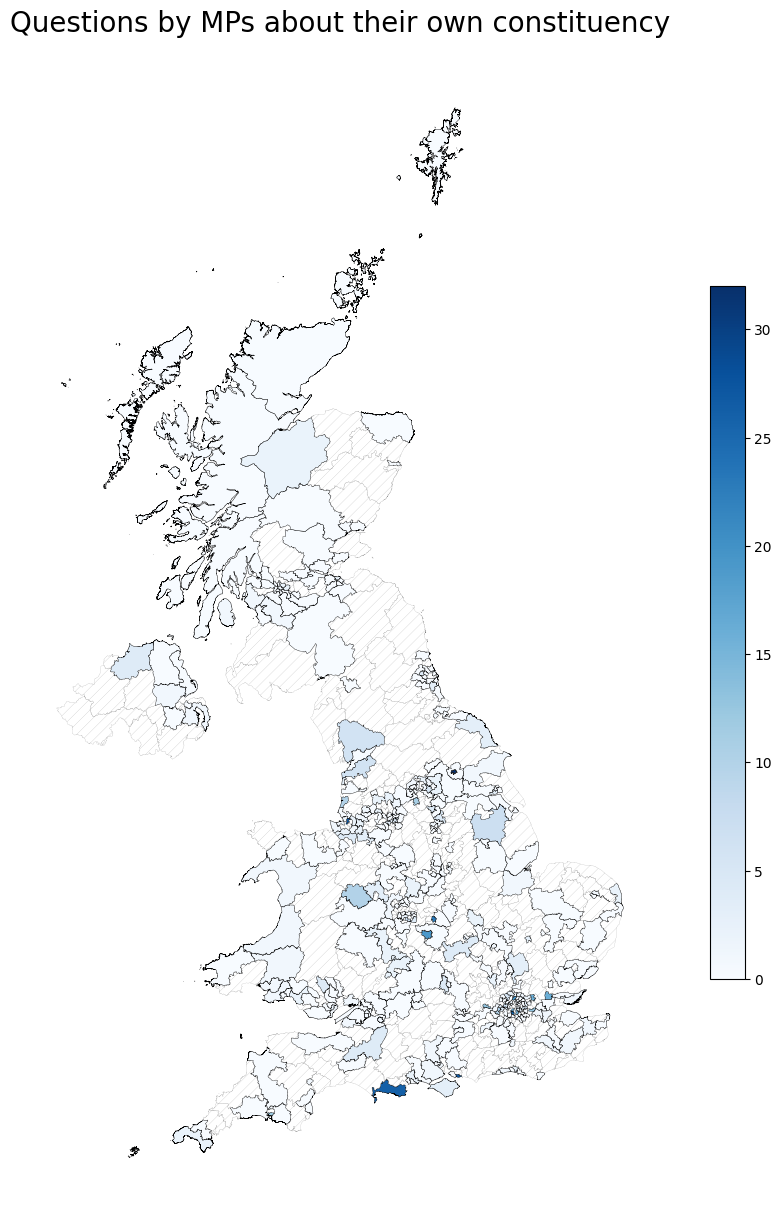

In [102]:
fig, ax = plt.subplots(figsize=(15, 15))


same_const.plot(ax=ax, column="same_const", legend=True, cmap="Blues", edgecolor="black", linewidth=0.3, legend_kwds={"shrink":0.6}) #cmap="OrRd"
same_const[same_const["same_const"].isnull()].plot(ax=ax, color="white", edgecolor="black", linewidth=0.1, hatch="///", alpha=0.5)
plt.title("Questions by MPs about their own constituency", fontsize=20)
# remove axis labels
ax.set_axis_off()
plt.rcParams['hatch.linewidth'] = 0.1

In [318]:
print(len(same_const[same_const["same_const"] >= 1])/650)
same_const.sort_values(by="proportion_same_const", ascending=False).head(20)

0.2123076923076923


,constLabel,geometry,same_const,total_questions,proportion_same_const
255,Scarborough and Whitby,"POLYGON ((478799.000 519215.100, 478803.500 51...",3.0,3.0,1.000000
428,Islington North,"POLYGON ((528839.855 187215.909, 528857.466 18...",1.0,1.0,1.000000
100,Rossendale and Darwen,"POLYGON ((388662.753 425190.573, 388691.404 42...",2.0,2.0,1.000000
310,Leeds West,"POLYGON ((427361.903 430100.305, 427320.398 43...",1.0,1.0,1.000000
503,Basildon and Billericay,"POLYGON ((566278.830 197419.550, 566289.162 19...",16.0,18.0,0.888889
376,South Dorset,"POLYGON ((382017.820 95732.800, 382014.920 957...",26.0,34.0,0.764706
378,Bexleyheath and Crayford,"POLYGON ((554503.796 178268.500, 554398.696 17...",13.0,23.0,0.565217
265,Gainsborough,"POLYGON ((509480.700 408253.498, 509526.402 40...",7.0,14.0,0.500000
470,Coventry North East,"POLYGON ((434074.760 283790.550, 434074.929 28...",23.0,54.0,0.425926
289,St Helens South and Whiston,"POLYGON ((346696.801 397021.503, 346696.813 39...",2.0,5.0,0.400000


In [323]:
joined_df[joined_df["question_const" ] == "South Dorset"]

,question,question_const,MP,MP_const,MP_const_geometry,same_const
220,https://id.parliament.uk/eIPt42gK,South Dorset,Yvette Cooper,Normanton Pontefract and Castleford,"POLYGON ((446137.370 427478.620, 446141.060 42...",False
221,https://id.parliament.uk/8kWXGOpu,South Dorset,Yvette Cooper,Normanton Pontefract and Castleford,"POLYGON ((446137.370 427478.620, 446141.060 42...",False
222,https://id.parliament.uk/xxACE3tQ,South Dorset,Yvette Cooper,Normanton Pontefract and Castleford,"POLYGON ((446137.370 427478.620, 446141.060 42...",False
417,https://id.parliament.uk/sGOOl3jA,South Dorset,Stephen Metcalfe,South Basildon and East Thurrock,"POLYGON ((577858.599 190816.499, 577862.499 19...",False
691,https://id.parliament.uk/5chA3Loh,South Dorset,Caroline Lucas,Brighton Pavilion,"POLYGON ((531324.608 103741.597, 531323.782 10...",False
739,https://id.parliament.uk/mneTDEUl,South Dorset,Jim Shannon,Strangford,"POLYGON ((166192.764 532012.369, 166196.879 53...",False
889,https://id.parliament.uk/7Xkg0LCT,South Dorset,John Healey,Wentworth and Dearne,"POLYGON ((436259.099 397360.096, 436257.599 39...",False
895,https://id.parliament.uk/b0gt7M4B,South Dorset,John Healey,Wentworth and Dearne,"POLYGON ((436259.099 397360.096, 436257.599 39...",False
947,https://id.parliament.uk/gZ5T57HR,South Dorset,Julian Sturdy,York Outer,"POLYGON ((454141.301 456553.402, 454225.598 45...",False
1415,https://id.parliament.uk/TSh8ReyK,South Dorset,Richard Drax,South Dorset,"POLYGON ((382017.820 95732.800, 382014.920 957...",True


<Axes: xlabel='same_const', ylabel='Count'>

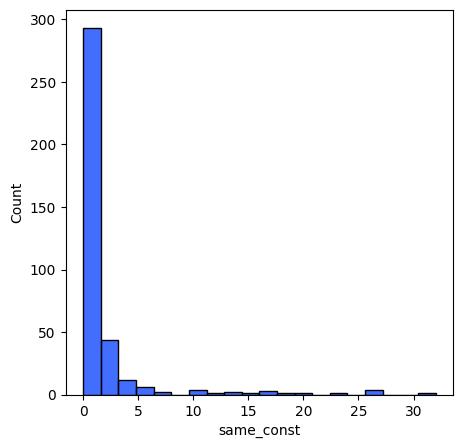

In [103]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=same_const, x="same_const", bins=20)

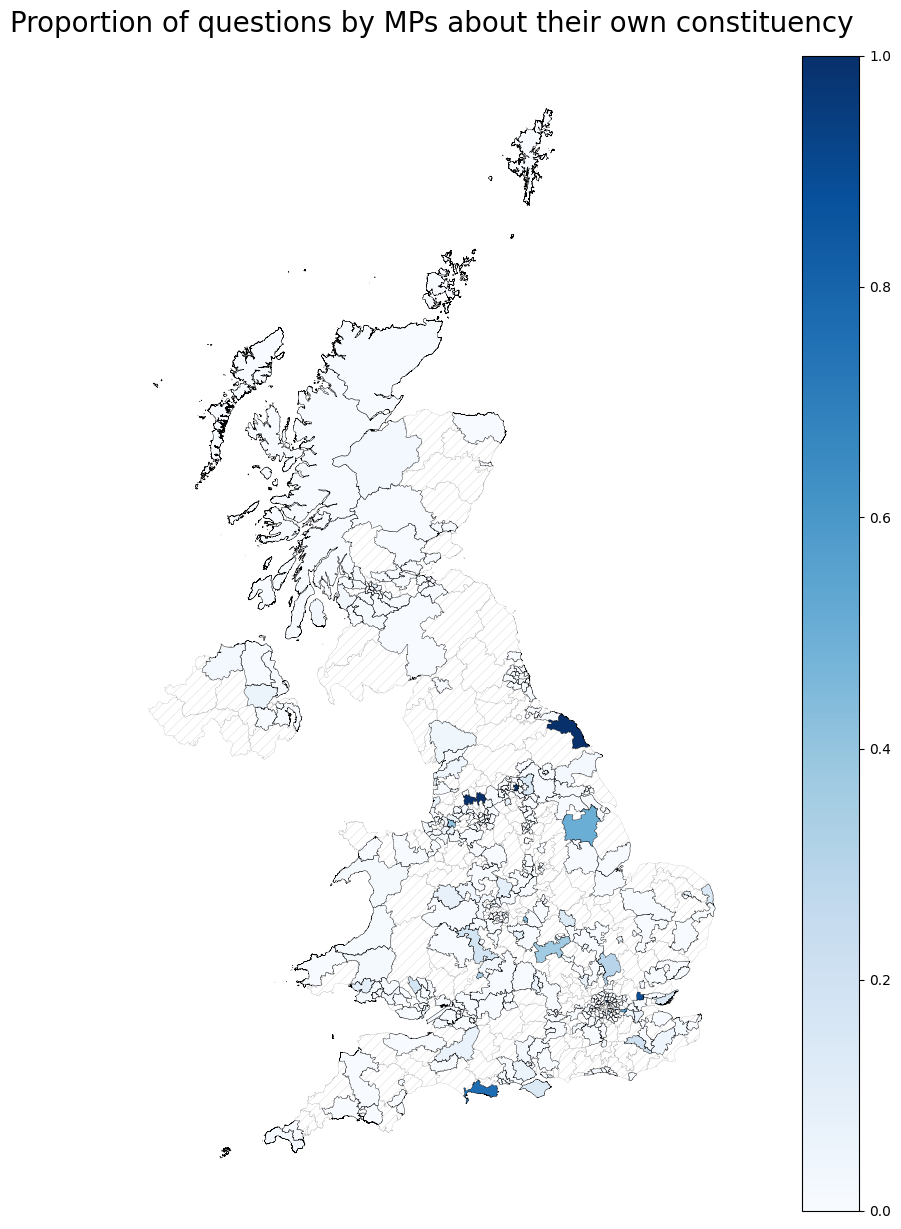

In [104]:
same_const["proportion_same_const"] = same_const["same_const"] / same_const["total_questions"]
fig, ax = plt.subplots(figsize=(15, 15))
same_const.plot(ax=ax, column="proportion_same_const", legend=True, cmap="Blues", edgecolor="black", linewidth=0.3)
same_const[same_const["proportion_same_const"].isna()].plot(ax=ax, color="white", edgecolor="black", linewidth=0.1, hatch="///", alpha=0.5)
plt.rcParams['hatch.linewidth'] = 0.1
plt.title("Proportion of questions by MPs about their own constituency", fontsize=20)



ax.set_axis_off()

<Axes: xlabel='proportion_same_const', ylabel='Count'>

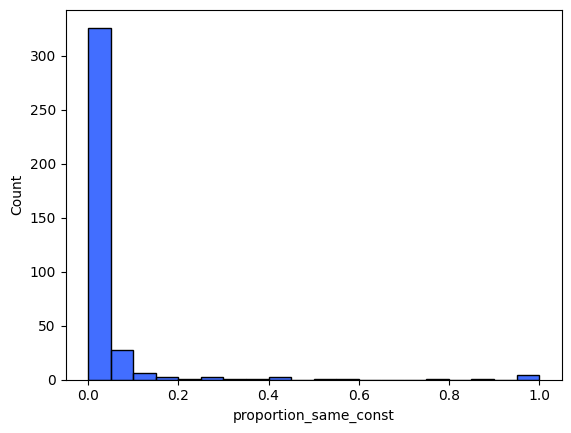

In [105]:
# plot a graph showing the distribution of proportions of questions asked by MPs about their own constituency using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(same_const["proportion_same_const"], bins=20)

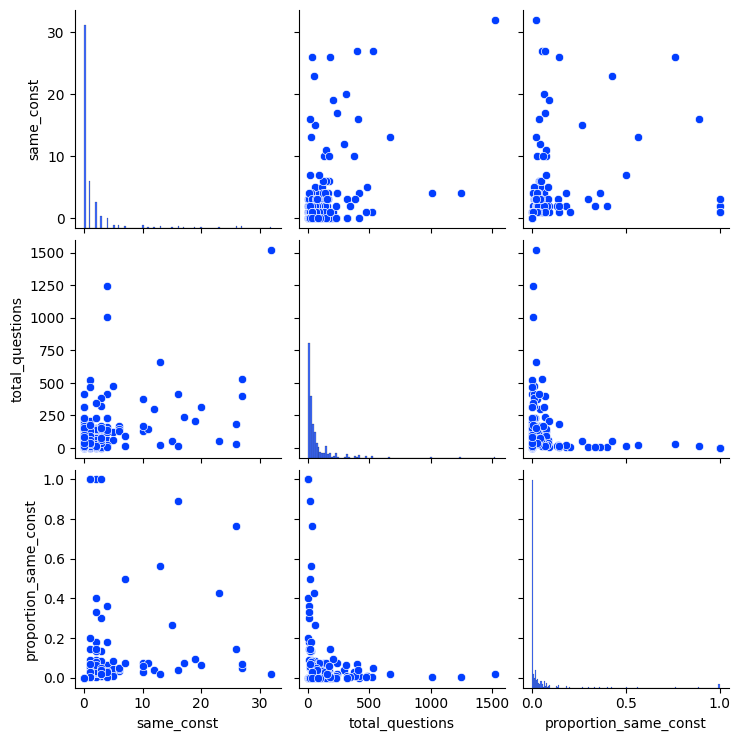

In [106]:
import seaborn as sns
sns.pairplot(same_const)

In [107]:
same_const.sort_values("total_questions", ascending=False).head(10)

,constLabel,geometry,same_const,total_questions,proportion_same_const
160,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45...",32.0,1524.0,0.020997
514,Wentworth and Dearne,"POLYGON ((436259.099 397360.096, 436257.599 39...",4.0,1244.0,0.003215
545,Solihull,"POLYGON ((416312.499 283687.905, 416335.898 28...",4.0,1008.0,0.003968
630,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17...",13.0,664.0,0.019578
83,Liverpool Walton,"POLYGON ((338860.901 397978.399, 338935.099 39...",27.0,529.0,0.051040
508,Strangford,"POLYGON ((166192.764 532012.369, 166196.879 53...",1.0,524.0,0.001908
444,Hendon,"POLYGON ((517435.816 194420.872, 517437.398 19...",5.0,480.0,0.010417
583,Islington South and Finsbury,"POLYGON ((529818.713 184985.372, 529825.652 18...",1.0,472.0,0.002119
34,Sefton Central,"POLYGON ((330283.243 398043.486, 330281.620 39...",0.0,416.0,0.000000
47,Newcastle upon Tyne Central,"POLYGON ((420660.103 563375.205, 420642.500 56...",4.0,415.0,0.009639


In [108]:
same_const.sort_values("same_const", ascending=False).head(10)

,constLabel,geometry,same_const,total_questions,proportion_same_const
160,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45...",32.0,1524.0,0.020997
83,Liverpool Walton,"POLYGON ((338860.901 397978.399, 338935.099 39...",27.0,529.0,0.051040
349,Portsmouth South,"MULTIPOLYGON (((463418.899 101737.297, 464118....",27.0,401.0,0.067332
477,Tooting,"POLYGON ((525760.499 174242.503, 525769.000 17...",26.0,181.0,0.143646
376,South Dorset,"POLYGON ((382017.820 95732.800, 382014.920 957...",26.0,34.0,0.764706
470,Coventry North East,"POLYGON ((434074.760 283790.550, 434074.929 28...",23.0,54.0,0.425926
209,Hornsey and Wood Green,"POLYGON ((531727.046 191669.493, 531730.749 19...",20.0,312.0,0.064103
345,Warwick and Leamington,"POLYGON ((422669.004 265347.305, 422685.197 26...",19.0,205.0,0.092683
77,Battersea,"POLYGON ((528564.154 177799.665, 528575.613 17...",17.0,237.0,0.071730
600,Romford,"POLYGON ((548106.898 193800.904, 548224.704 19...",16.0,411.0,0.038929


In [109]:
same_const.sort_values(by="total_questions", ascending=False).head(10)

,constLabel,geometry,same_const,total_questions,proportion_same_const
160,York Central,"POLYGON ((461843.903 454083.299, 461851.703 45...",32.0,1524.0,0.020997
514,Wentworth and Dearne,"POLYGON ((436259.099 397360.096, 436257.599 39...",4.0,1244.0,0.003215
545,Solihull,"POLYGON ((416312.499 283687.905, 416335.898 28...",4.0,1008.0,0.003968
630,Slough,"POLYGON ((494342.702 178838.997, 494338.497 17...",13.0,664.0,0.019578
83,Liverpool Walton,"POLYGON ((338860.901 397978.399, 338935.099 39...",27.0,529.0,0.051040
508,Strangford,"POLYGON ((166192.764 532012.369, 166196.879 53...",1.0,524.0,0.001908
444,Hendon,"POLYGON ((517435.816 194420.872, 517437.398 19...",5.0,480.0,0.010417
583,Islington South and Finsbury,"POLYGON ((529818.713 184985.372, 529825.652 18...",1.0,472.0,0.002119
34,Sefton Central,"POLYGON ((330283.243 398043.486, 330281.620 39...",0.0,416.0,0.000000
47,Newcastle upon Tyne Central,"POLYGON ((420660.103 563375.205, 420642.500 56...",4.0,415.0,0.009639


In [110]:
same_const

,constLabel,geometry,same_const,total_questions,proportion_same_const
0,Witney,"POLYGON ((442095.596 201006.402, 442061.503 20...",0.0,20.0,0.000000
1,Gower,"POLYGON ((266481.698 209849.500, 266493.299 20...",1.0,86.0,0.011628
2,Dumfries and Galloway,"MULTIPOLYGON (((266001.597 603288.500, 266016....",NaN,NaN,NaN
3,Blaydon,"POLYGON ((411599.496 556797.514, 411599.430 55...",0.0,48.0,0.000000
4,Banff and Buchan,"MULTIPOLYGON (((352324.388 867640.741, 352328....",0.0,7.0,0.000000
...,...,...,...,...,...
645,East Devon,"POLYGON ((294508.731 96046.540, 294508.510 960...",NaN,NaN,NaN
646,Loughborough,"POLYGON ((450929.602 315678.597, 450928.201 31...",NaN,NaN,NaN
647,Jarrow,"POLYGON ((435134.003 566077.102, 435320.399 56...",NaN,NaN,NaN
648,Buckingham,"POLYGON ((460619.899 235588.003, 460625.870 23...",NaN,NaN,NaN


In [111]:
"""
SPARQL query to get the current ministers in the 58th parliment and their constituencies
"""


# help from https://rebeccabilbro.github.io/sparql-from-python/
# also from https://stackoverflow.com/questions/51673685/how-to-show-or-filter-by-qualifier
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd

question_df = pd.DataFrame()
sparql  = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setQuery("""


SELECT ?person ?const ?personLabel ?constLabel ?ministerPositionLabel
WHERE
{
  # gets members of the 58th parliment and their constituency
  ?person p:P39 ?position.
  ?position ps:P39 wd:Q77685926.
  ?position pq:P768 ?const.
  
  # gets people who hold a ministerial position
  ?person wdt:P39 ?ministerPosition.
  ?ministerPosition wdt:P361 wd:Q112014.
  
  # gets the node for the position, so I can later check the end time qualifier
  ?person p:P39 ?positionStatement.
  ?positionStatement ps:P39 ?ministerPosition. 

  FILTER (
    NOT EXISTS { ?positionStatement pq:P582 ?dateEnded. } # no end date, so still have this role
    ||
    EXISTS { 
      ?positionStatement pq:P582 ?dateEnded.
      FILTER (?dateEnded >= "2023-01-01+00:00"^^xsd:dateTime) # end date that is within the time period of the questions
    }
  )
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
  
}
""")

sparql.setReturnFormat(JSON)
result = sparql.query().convert()
# results -> bindings returns a list of dictionaries
result = result["results"]["bindings"]

# removed type from the results
for item in result:
    for key in item:
        item[key] = item[key]["value"]

In [112]:
cabinet_MPs = pd.DataFrame(result)
cabinet_MPs.drop_duplicates(subset=["constLabel"], inplace=True)
len(cabinet_MPs)

38

In [113]:
len(cabinet_MPs["personLabel"].unique())

38

In [114]:
# for cabinet_const in list(cabinet_MPs["constLabel"].unique()):
#     print(same_const[same_const["constLabel"] == cabinet_const]["proportion_same_const"])

# get a df of the constituencies of the cabinet ministers
cabinet_constituencies = same_const[same_const["constLabel"].isin(list(cabinet_MPs["constLabel"].unique()))]
cabinet_constituencies.sort_values("total_questions", ascending=False)

,constLabel,geometry,same_const,total_questions,proportion_same_const
313,Tatton,"POLYGON ((371724.899 387929.696, 371741.199 38...",0.0,45.0,0.000000
302,Norwich North,"MULTIPOLYGON (((619850.003 310507.198, 619823....",1.0,15.0,0.066667
579,Esher and Walton,"POLYGON ((512535.701 168963.404, 512560.197 16...",0.0,3.0,0.000000
2,Dumfries and Galloway,"MULTIPOLYGON (((266001.597 603288.500, 266016....",NaN,NaN,NaN
17,North West Durham,"POLYGON ((419489.254 556877.150, 419365.002 55...",NaN,NaN,NaN
24,Wyre and Preston North,"POLYGON ((334436.943 444632.775, 334398.488 44...",NaN,NaN,NaN
63,Braintree,"POLYGON ((564926.600 243518.903, 564944.896 24...",NaN,NaN,NaN
71,Cheltenham,"POLYGON ((399393.403 222708.400, 399382.503 22...",NaN,NaN,NaN
120,Surrey Heath,"POLYGON ((496215.798 166832.904, 496250.502 16...",NaN,NaN,NaN
154,Fareham,"POLYGON ((451762.197 111202.398, 451748.700 11...",NaN,NaN,NaN


In [115]:
print("Number of questions asked per MP (by those who asked any)")
print(f"All MPs: {same_const['total_questions'].mean()}")
print(f"Cabinet ministers: {cabinet_constituencies['total_questions'].mean()}")
print()

print(f"Average proportion of questions to do with their own constituency (for those who asked any)")
print(f"All MPs: {same_const['proportion_same_const'].mean()}")
print(f"Cabinet ministers: {cabinet_constituencies['proportion_same_const'].mean()}")
print()

print(f"Proportion of MPs who asked at least one question")
print(f"All MPs: {(~same_const['proportion_same_const'].isna()).sum() / len(same_const)}")
print(f"Cabinet ministers: {(~cabinet_constituencies['proportion_same_const'].isna()).sum() / len(cabinet_constituencies)}")


Number of questions asked per MP (by those who asked any)
All MPs: 71.44946808510639
Cabinet ministers: 21.0

Average proportion of questions to do with their own constituency (for those who asked any)
All MPs: 0.03728963538191026
Cabinet ministers: 0.022222222222222223

Proportion of MPs who asked at least one question
All MPs: 0.5784615384615385
Cabinet ministers: 0.07894736842105263


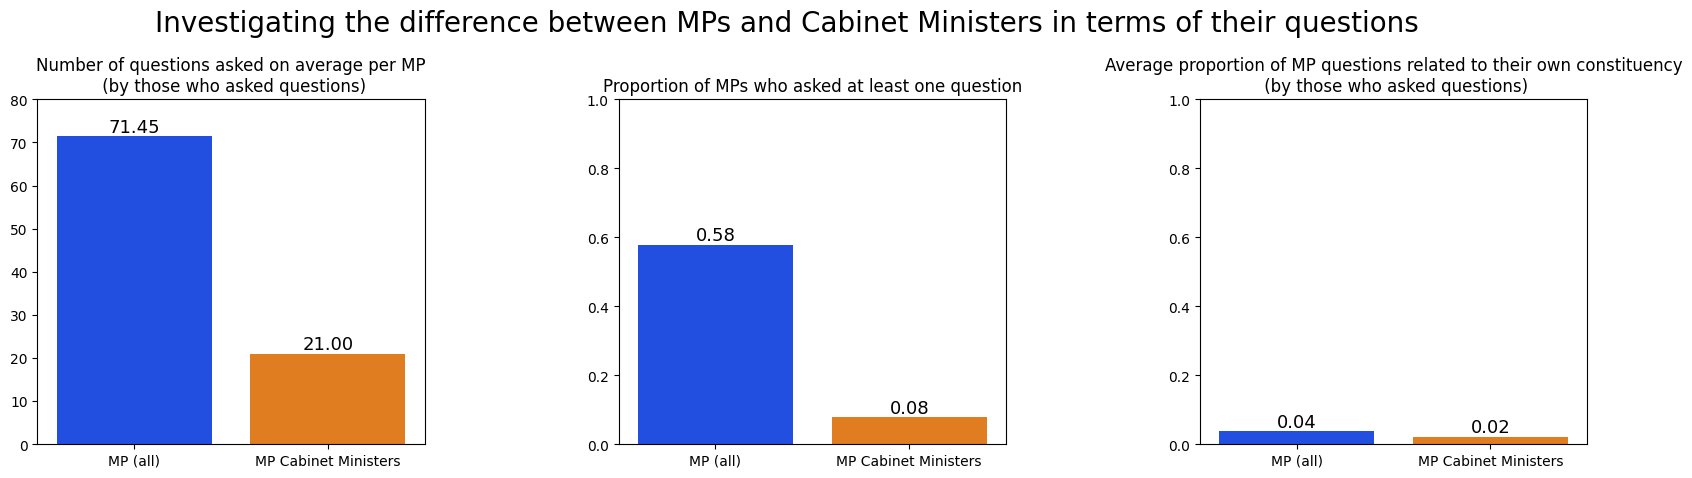

In [144]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=3)

# spacing between subplots
plt.subplots_adjust(wspace=0.5)

# change colour of bars
sns.set_palette("bright")

sns.barplot(x=["MP (all)"], y=[same_const['total_questions'].mean()], ax=axs[0])
sns.barplot(x=["MP Cabinet Ministers"], y=[cabinet_constituencies['total_questions'].mean()], ax=axs[0])
axs[0].set_title("Number of questions asked on average per MP\n (by those who asked questions)")
axs[0].set_ylim(0, 80)

sns.barplot(x=["MP (all)"], y=[(~same_const['total_questions'].isna()).sum()/len(same_const)], ax=axs[1])
sns.barplot(x=["MP Cabinet Ministers"], y=[(~cabinet_constituencies['proportion_same_const'].isna()).sum()/len(cabinet_constituencies)], ax=axs[1])
axs[1].set_title("Proportion of MPs who asked at least one question")
axs[1].set_ylim(0, 1)


sns.barplot(x=["MP (all)"], y=[same_const['proportion_same_const'].mean()], ax=axs[2])
sns.barplot(x=["MP Cabinet Ministers"], y=[cabinet_constituencies['proportion_same_const'].mean()], ax=axs[2])
axs[2].set_title("Average proportion of MP questions related to their own constituency\n (by those who asked questions)")
axs[2].set_ylim(0, 1)


fig.suptitle("Investigating the difference between MPs and Cabinet Ministers in terms of their questions", fontsize=20)
fig.subplots_adjust(top=0.8)
for ax in axs:
    for i in range(2):
        ax.bar_label(ax.containers[i], fmt='%.2f', label_type="edge", fontsize=13)


In [146]:
len(same_const["proportion_same_const"])

650

In [117]:
same_const["total_questions"].max()

1524.0